# Completeness relation: a wider picture

The SiegPy module only provides the ability to study the convergence of the completeness relation one test function at a time, but you may want a wider picture, involving the results of many test functions. This notebook aims at showing how easily you can get that kind of information.

To that end, the same test example is presented for the two types of test functions (rectangular and Gaussian). It consists in comparing the convergence of the completeness relation for the exact CR and the MLE of the CR while varying the width of the test functions and the number of states used in the CR.

## Initialization: create two basis sets

Again, it is more convenient to use a lot of Siegert states, and we will reuse the binary file `siegerts.dat` to save the computation time of finding the Siegert states. Finding the continuum states is not as time consuming, since they can have any real, positive wavenumber.

### Import useful modules and classes

In [1]:
# Make the notebook aware of some of the SiegPy module classes
from siegpy import SWPBasisSet, Rectangular, Gaussian
# Other imports
import numpy as np
import matplotlib.pyplot as plt

### Read a data file containing a lot of Siegert states

This allows the creation of a large basis set without using the time-consuming `find_siegert_states` method.

In [2]:
siegerts = SWPBasisSet.from_file('siegerts.dat')
l = siegerts[0].potential.width

### Create an exact basis-set, made of bound and continuum states.

The bound states can be taken from the previous calculation finding the Siegert states (given that bound states are nothing but a particuliar type of Siegert states), while the continuum states are discretized over a grid of real wavenumbers. This grid is caracterized by the grid step `h_k` and the maximal wavenumber `k_max`.

In [3]:
# Find the continuum states
h_k = 0.1 # Grid step for the continuum states wavenumbers
k_max = abs(siegerts.resonants[-1].wavenumber)+h_k # Maximal wavenumber
continuum = SWPBasisSet.find_continuum_states(siegerts[0].potential, k_max, h_k)

In [4]:
# Create the exact basis set
exact = siegerts.bounds + continuum

## Case 1: centered rectangular functions of varying width

### Define the test functions

The widths $a$ of the rectangular functions are varied comparatively to the width of the potential $l$. In order to have the widest picture possible, a logarithmic scale will be used for the x-axis of the plot, representing the width factors $a/l$.

In [5]:
x_c = 0. #center of the test functions
width_factors = 10**(np.linspace(-4, -0.01, 25))
rects = [Rectangular.from_width_and_center(a_over_l*l, x_c) for a_over_l in width_factors]
print(["{:.3e}".format(rect.width/l) for rect in rects])

['1.000e-04', '1.466e-04', '2.150e-04', '3.153e-04', '4.624e-04', '6.780e-04', '9.943e-04', '1.458e-03', '2.138e-03', '3.135e-03', '4.597e-03', '6.741e-03', '9.886e-03', '1.450e-02', '2.126e-02', '3.117e-02', '4.571e-02', '6.703e-02', '9.829e-02', '1.441e-01', '2.113e-01', '3.099e-01', '4.545e-01', '6.664e-01', '9.772e-01']


### Compute the convergence of the MLE completeness relation for each rectangular functions

In [6]:
CR_MLE_conv = [siegerts.MLE_completeness_convergence(rect) for rect in rects] 

### Compute the exact completeness relation for each rectangular functions

In [7]:
CR_exact_conv = [exact.exact_completeness_convergence(rect) for rect in rects]

### Plot the results

We now present the evolution of the completeness relation evaluated for multiple rectangular functions centered in region $II$ and of various width $a$. The plot therefore uses $\frac{a}{l}$ as the x-axis (where $l$ is the width of the potential). There are 4 different colors, each representing a different number of resonant couples $N_{res}$ used in the evaluation of the CR.

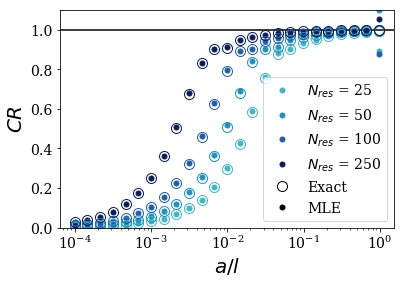

In [8]:
def find_icont(ires, exact, siegerts):
    """
    Function returning the index of the continuum states corresponding to
    the absolute value of the wavenumbers of the resonant states
    given their index ires.
    """
    cont_wn = [c.wavenumber for c in exact.continuum.even]
    sieg_wn = np.array([abs(s.wavenumber) for s in siegerts.resonants])
    ires = [i-1 for i in ires]
    kres = sieg_wn[ires]
    return [(np.abs(cont_wn-k)).argmin() for k in kres]


# Number of resonant states to use in the completeness relation:
ires = [25, 50, 100, 250]  
# Corresponding index of the continuum states:
icont = find_icont(ires, exact, siegerts)
# Set some global values
colors = ['#41b6c4', '#1d91c0', '#225ea8', '#081d58']
ms_res = 5  # Marker size for resonant states
ms_cont = 10  # Marker size for continuum states
# Plot the expected result: the CR should tend to 1
plt.axhline(1, color='k', ls='-', lw=1.5)
# Plot the points corresponding the the Siegert basis set
for j, i in enumerate(ires):
    CR = [CR_conv[i] for k, CR_conv in CR_MLE_conv]
    plt.plot(width_factors, np.real(CR), color=colors[j],
             marker='o', ls='', label='$N_{res}$ = '+str(i), ms=ms_res)
# Plot the points corresponding the the exact basis set
for j, i in enumerate(icont):
    CR = [CR_conv[i] for k, CR_conv in CR_exact_conv]
    plt.plot(width_factors, np.real(CR), color=colors[j], 
             marker='o', mfc='none', ls='', ms=ms_cont)
# Set values for the plot
plt.xlabel('$a/l$')
plt.ylabel('$CR$')
ymax = 1.1
plt.ylim(0, ymax)
plt.xscale('log')
plt.plot(10**(-4), 2*ymax, label='Exact', marker='o', 
         mfc='none', ls='', ms=ms_cont, color='k')
plt.plot(10**(-4), 2*ymax, label='MLE', marker='o', 
         ls='', color='k', ms=ms_res)
plt.legend()
plt.savefig('CR_rect_multiple_centered.pdf')
plt.show()

The main point is that the exact CR and the approximate MLE of the CR follow each other closely: a basis set of Siegert states with the resonant states up to a certain energy is as complete as a basis set made of the bound states and the continuum states up to the same energy.

For almost every width $a$, increasing the number of resonant couples taken into account lead to an increase of the completeness relation. This is not the case when the test function is close to the width of the potential: these correspond to the problematic cases that were presented in the previous notebooks.

Not surprisingly, the basis sets are more efficient to reproduce large test functions: it requires highly oscillating Siegert states (*i.e.* those of high energy) to reproduce thin rectangular functions.

## Case 2: centered Gaussian functions of varying width

The width of the Gaussian function is varied comparatively to the width of the potential.

### Define the test functions

In [9]:
x_c = 0. #center of the test functions
width_factors = 10**(np.linspace(-4, -0.01, 25))
gauss = [Gaussian(width_factor*l, x_c) for width_factor in width_factors]

### Compute the convergence of the MLE completeness relation for each Gaussian functions

In [10]:
CR_MLE_conv_g = [siegerts.MLE_completeness_convergence(g) for g in gauss]

/Users/maximemoriniere/Documents/SiegPy/siegpy/swpeigenstates.py:550: RuntimeWarning: invalid value encountered in cdouble_scalars
  expkp * (erf(zkmp) + 1) - expkm * (erf(zkpm) - 1))
/Users/maximemoriniere/Documents/SiegPy/siegpy/swpeigenstates.py:552: RuntimeWarning: invalid value encountered in cdouble_scalars
  term2 = factor2 * (expqp * (erf(zqpp) - erf(zqmp)) -
/Users/maximemoriniere/Documents/SiegPy/siegpy/swpeigenstates.py:553: RuntimeWarning: invalid value encountered in cdouble_scalars
  expqm * (erf(zqmm) - erf(zqpm)))


### Compute the exact completeness relation for each Gaussian functions

In [11]:
CR_exact_conv_g = [exact.exact_completeness_convergence(g) for g in gauss] 

/Users/maximemoriniere/Documents/SiegPy/siegpy/swpeigenstates.py:814: RuntimeWarning: invalid value encountered in cdouble_scalars
  termk1 = expkp * (fm * (erf(zkpp) - 1.) - fp * (erf(zkmp) + 1.))
/Users/maximemoriniere/Documents/SiegPy/siegpy/swpeigenstates.py:815: RuntimeWarning: invalid value encountered in cdouble_scalars
  termk2 = expkm * (fp * (erf(zkpm) - 1.) - fm * (erf(zkmm) + 1.))
/Users/maximemoriniere/Documents/SiegPy/siegpy/swpeigenstates.py:818: RuntimeWarning: invalid value encountered in cdouble_scalars
  termq1 = expqp * (erf(zqpp) - erf(zqmp))
/Users/maximemoriniere/Documents/SiegPy/siegpy/swpeigenstates.py:819: RuntimeWarning: invalid value encountered in cdouble_scalars
  termq2 = expqm * (erf(zqpm) - erf(zqmm))


The RuntimeWaring is due to the fact that infinite values are found somewhere in the evaluation of the scalar products between eigenstates and a Gaussian test function. This will cause the absence of some values in the plot.

### Plot the results

The results are plotted in the same manner as the previous case:

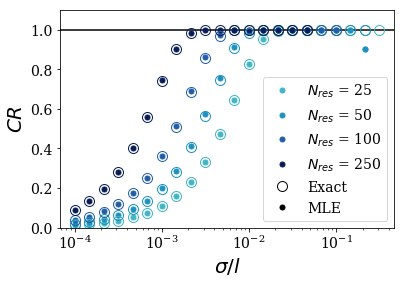

In [12]:
# Plot the expected result: the CR should tend to 1
plt.axhline(1, color='k', ls='-', lw=1.5)
# Plot the points corresponding the the Siegert basis set
for j, i in enumerate(ires):
    CR = [CR_conv[i] for k, CR_conv in CR_MLE_conv_g]
    plt.plot(width_factors, np.real(CR), color=colors[j],
             marker='o', ls='', label='$N_{res}$ = '+str(i), ms=ms_res)
# Plot the points corresponding the the exact basis set
for j, i in enumerate(icont):
    CR = [CR_conv[i] for k, CR_conv in CR_exact_conv_g]
    plt.plot(width_factors, np.real(CR), color=colors[j], 
             marker='o', mfc='none', ls='', ms=ms_cont)
# Set values for the plot
plt.xlabel('$\sigma/l$')
plt.ylabel('$CR$')
ymax = 1.1
plt.ylim(0, ymax)
plt.xscale('log')
plt.plot(10**(-4), 2*ymax, label='Exact', marker='o', 
         mfc='none', ls='', ms=ms_cont, color='k')
plt.plot(10**(-4), 2*ymax, label='MLE', marker='o', 
         ls='', color='k', ms=ms_res)
plt.legend()
plt.savefig('CR_gauss_multiple_centered.pdf')
plt.show()

The conclusions are the same as before:

* the exact CR and the approximate MLE of the CR follow each other closely,

* for a width $\sigma$, increasing the number of resonant couples taken into account lead to an increase of the completeness relation. There are however numerical instabilities for the largest numbers of resonant states when $\sigma$ is too large and spreads over multiple regions. This is shown by the absence of some points in the plot for large values of $\sigma / l$,

* the basis sets are more efficient to reproduce large test functions.


Comparing both plots, you can see it is easier to exactly reproduce a Gaussian rather than a Rectangular function: for a large set of test functions, the CR is exactly converged to 1. For $a / l > 10^{-2}$, it even required less than 25 resonant couples to reach convergence.